# Tutorial 02 - Vanilla Learning

A vanilla learning process starts from scratch with the CommonRoad-RL environment `commonroad-v1` and a designated RL model, [PPO2](https://stable-baselines.readthedocs.io/en/master/modules/ppo2.html) for example. This tutorial explains the following operations:  
* how the RL environment and the RL model are configured before the learning begins
* how training and testing sessions are carried out differently
* how callback functions are created and attached to evaluate the learning
* how results are stored for later inspection or reuse

Note that all funcionalities/code snippets from this tutorial are provided in `./commonroad_rl/train_model.py`. Please use the full functionality of `train_model.py` to perform your other experiments.

## 0. Preparation

Please make sure the training and testing data are prepared, otherwise see **Tutorial 01 - Data Preprocessing**. Also, check the followings:
* current path is at `commonroad-rl/commonroad_rl`, i.e. one upper layer to the `tutorials` folder
* interactive python kernel is triggered from the correct environment

In [ ]:
# Check current path
%cd ..
%pwd

# Check interactive python kernel
import sys
sys.executable

In [1]:

import sys
from pathlib import Path
from warnings import warn

# Check and set current path
current_path = Path().absolute()
if current_path.name == "tutorials":
    base_path = current_path.parent
elif current_path.name != "commonroad_rl":
    warn("Expected different path: Please ensure that the pwd is at commonroad-rl/commonroad_rl")
else:
    base_path = current_path

%cd $base_path
%pwd

sys.path.append(base_path)
work_path = base_path.parent
sys.path.append(work_path)

print(f"work_path:{work_path}")
print(f"base_path:{base_path}")

# Check interactive python kernel
import sys
sys.executable

D:\dev\mygithub\AutoDrivingRL\commonroad-rl\commonroad_rl
work_path:D:\dev\mygithub\AutoDrivingRL\commonroad-rl
base_path:D:\dev\mygithub\AutoDrivingRL\commonroad-rl\commonroad_rl


'D:\\apps\\Anaconda3\\python.exe'

## 1. Load RL environment and model settings

Before the learning begins, both the RL environment and the RL model are to be specified. This is done with the files of environment configurations and model hyperparameters respectively.

To configure an environment, simply set the values in `./commonroad_rl/gym_commonroad/config.yaml`. Please see the `./commonroad_rl/gym_commonroad/README.md` file for a full description. 

To adjust the hyperparameters of a model, go to `./commonroad_rl/hyperparams/{model}.yml`. Alternatively, the parameters can be read in and set with easy assignments.

Furthermore, we save these settings in the model results folder for later use.

In [2]:
# %cd $base_path
%cd $work_path

import os
import yaml
import copy

# Read in environment configurations
env_configs = {}
with open("commonroad_rl/gym_commonroad/configs.yaml", "r") as config_file:
    env_configs = yaml.safe_load(config_file)["env_configs"]
    
# Change a configuration directly
env_configs["reward_type"] = "hybrid_reward"

# Save settings for later use
log_path = "commonroad_rl/tutorials/logs/"
os.makedirs(log_path, exist_ok=True)

with open(os.path.join(log_path, "environment_configurations.yml"), "w") as config_file:
    yaml.dump(env_configs, config_file)

# Read in model hyperparameters
hyperparams = {}
with open("commonroad_rl/hyperparams/ppo.yml", "r") as hyperparam_file:
    hyperparams = yaml.safe_load(hyperparam_file)["commonroad-v1"]
    
# Save settings for later use
with open(os.path.join(log_path, "model_hyperparameters.yml"), "w") as hyperparam_file:
    yaml.dump(hyperparams, hyperparam_file)
    
# Remove `normalize` as it will be handled explicitly later
if "normalize" in hyperparams:
    del hyperparams["normalize"]

D:\dev\mygithub\AutoDrivingRL\commonroad-rl


## 2. Create a training environment
Now we are ready to create our customized RL environment `commonroad-v1` with the above configurations.  
Based on the API of [OpenAI gym](https://gym.openai.com/docs/), keyword arguments can be appended and passed over to the environment initializer. This comes in handy as we configure training/testing environments and specify data paths.  
Moreover, we utilize the [Monitor Wrapper](https://stable-baselines.readthedocs.io/en/master/common/monitor.html) and [Vectorized Environments](https://stable-baselines.readthedocs.io/en/master/guide/vec_envs.html) from OpenAI Stable Baselines to track and organize the learning process. 

In [8]:
!pip install aenum

In [3]:
%cd $work_path

import gymnasium as gym
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.vec_env import DummyVecEnv, VecNormalize

# import commonroad_rl.gym_commonroad
from commonroad_rl.gym_commonroad.commonroad_env import CommonroadEnv

# Create a Gym-based RL environment with specified data paths and environment configurations
meta_scenario_path = "commonroad_rl/tutorials/data/highD/pickles/meta_scenario"
training_data_path = "commonroad_rl/tutorials/data/highD/pickles/problem_train"
# training_env = gym.make("commonroad-v1", 
#                         meta_scenario_path=meta_scenario_path,
#                         train_reset_config_path= training_data_path,
#                         **env_configs)

training_env = CommonroadEnv(meta_scenario_path=meta_scenario_path,
                            train_reset_config_path= training_data_path,
                            **env_configs)

# Wrap the environment with a monitor to keep an record of the learning process
info_keywords=tuple(["is_collision", \
                     "is_time_out", \
                     "is_off_road", \
                     "is_friction_violation", \
                     "is_goal_reached"])
training_env = Monitor(training_env, log_path + "0", info_keywords=info_keywords)

# Vectorize the environment with a callable argument
def make_training_env():
    return training_env
training_env = DummyVecEnv([make_training_env])

# Normalize observations and rewards
training_env = VecNormalize(training_env, norm_obs=True, norm_reward=True)

D:\dev\mygithub\AutoDrivingRL\commonroad-rl


[DEBUG] commonroad_rl.gym_commonroad.commonroad_env - Initialization started
D:\apps\Anaconda3\lib\site-packages\commonroad\scenario\lanelet.py:1263: ShapelyDeprecationWarning: STRtree will be changed in 2.0.0 and will not be compatible with versions < 2.
  self._strtee = STRtree(list(self._buffered_polygons.values()))
[INFO] commonroad_rl.gym_commonroad.commonroad_env - Training on commonroad_rl/tutorials/data/highD/pickles/problem_train with 35 scenarios
[DEBUG] commonroad_rl.gym_commonroad.commonroad_env - Meta scenario path: commonroad_rl/tutorials/data/highD/pickles/meta_scenario
[DEBUG] commonroad_rl.gym_commonroad.commonroad_env - Training data path: commonroad_rl/tutorials/data/highD/pickles/problem_train
[DEBUG] commonroad_rl.gym_commonroad.commonroad_env - Testing data path: D:\dev\mygithub\AutoDrivingRL\commonroad-rl/pickles/problem_test
[DEBUG] commonroad_rl.gym_commonroad.commonroad_env - Initialization done


## 3. Create a testing environment
**Note**: Training environments are used the collect data to update the model. Testing environments are used to evaluate the performance of the model during training without updating the model.

Before starting the learning process, it is usual to prepare a testing environment to evaluate the training status during the process. For such, we simply append an additional key to the original environment configurations to create the testing environment. Then, we pass the testing environment to an evaluation callback, which constantly triggers several assessing episodes after a certain number, say 500 or 1000, of training steps.  

In addition, we create a customized [callback](https://stable-baselines.readthedocs.io/en/master/guide/callbacks.html) function to save the vectorized and normalized training environment wrapper whenever there is a new best model achieved during learning. This will be useful for later inspection and continual learning.

In [4]:
%cd $work_path

from stable_baselines3.common.callbacks import BaseCallback, EvalCallback

# Append the additional key
env_configs_test = copy.deepcopy(env_configs)
env_configs_test["test_env"] = True

# Create the testing environment
testing_data_path = "commonroad_rl/tutorials/data/highD/pickles/problem_test"
# testing_env = gym.make("commonroad-v1", 
#                         meta_scenario_path=meta_scenario_path,
#                         test_reset_config_path= testing_data_path,
#                         **env_configs_test)

testing_env = CommonroadEnv(meta_scenario_path=meta_scenario_path,
                            test_reset_config_path= testing_data_path,
                            **env_configs_test)

# Wrap the environment with a monitor to keep an record of the testing episodes 
log_path_test = "commonroad_rl/tutorials/logs/test"
os.makedirs(log_path_test, exist_ok=True)

testing_env = Monitor(testing_env, log_path_test + "/0", info_keywords=info_keywords)

# Vectorize the environment with a callable argument
def make_testing_env():
    return testing_env
testing_env = DummyVecEnv([make_testing_env])

# Normalize only observations during testing
testing_env = VecNormalize(testing_env, norm_obs=True, norm_reward=False, training=False)

# Define a customized callback function to save the vectorized and normalized environment wrapper
class SaveVecNormalizeCallback(BaseCallback):
    def __init__(self, save_path: str, verbose=1):
        super(SaveVecNormalizeCallback, self).__init__(verbose)
        self.save_path = save_path
        
    def _init_callback(self) -> None:
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)
    
    def _on_step(self) -> bool:
        save_path_name = os.path.join(self.save_path, "vecnormalize.pkl")
        self.model.get_vec_normalize_env().save(save_path_name)
        print("Saved vectorized and normalized environment to {}".format(save_path_name))
    
# Pass the testing environment and customized saving callback to an evaluation callback
# Note that the evaluation callback will triggers three evaluating episodes after every 500 training steps
save_vec_normalize_callback = SaveVecNormalizeCallback(save_path=log_path)
eval_callback = EvalCallback(testing_env, 
                             log_path=log_path, 
                             eval_freq=500, 
                             n_eval_episodes=3, 
                             callback_on_new_best=save_vec_normalize_callback)

[DEBUG] commonroad_rl.gym_commonroad.commonroad_env - Initialization started


D:\dev\mygithub\AutoDrivingRL\commonroad-rl


[INFO] commonroad_rl.gym_commonroad.commonroad_env - Testing on commonroad_rl/tutorials/data/highD/pickles/problem_test with 16 scenarios
[DEBUG] commonroad_rl.gym_commonroad.commonroad_env - Meta scenario path: commonroad_rl/tutorials/data/highD/pickles/meta_scenario
[DEBUG] commonroad_rl.gym_commonroad.commonroad_env - Training data path: D:\dev\mygithub\AutoDrivingRL\commonroad-rl/pickles/problem_train
[DEBUG] commonroad_rl.gym_commonroad.commonroad_env - Testing data path: commonroad_rl/tutorials/data/highD/pickles/problem_test
[DEBUG] commonroad_rl.gym_commonroad.commonroad_env - Initialization done


## 4. Create a model and start the learning
Now we are ready to start a learning process. To such end, we conveniently instantiate a model provided by OpenAI Stable Baselines. For example, we create a PPO2 agent and learn for 5000 steps.

D:\dev\mygithub\AutoDrivingRL\commonroad-rl
Eval num_timesteps=500, episode_reward=-28.71 +/- 104.69
Episode length: 24.33 +/- 3.30
New best mean reward!
Saved vectorized and normalized environment to commonroad_rl/tutorials/logs/vecnormalize.pkl


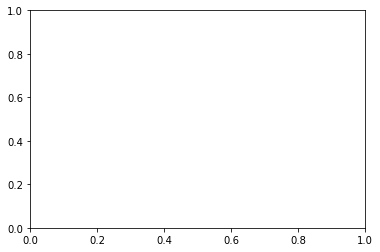

In [5]:
%cd $work_path

from stable_baselines3 import PPO

# Create the model together with its model hyperparameters and the training environment
model = PPO(env=training_env, **hyperparams)

# Start the learning process with the evaluation callback
n_timesteps=5000
model.learn(n_timesteps, eval_callback)

As seen, there are evaluation messages being printed out after every 500 time steps. Additionally, the environment wrapper is saved whenever a best mean reward (of the three evaluating episodes) is obtained.  

Now we conclude this tutorial by saving the trained model so far.

In [ ]:
# Specify the filename and save the model
model.save("tutorials/logs/intermediate_model")

At this point, a zip file `intermediate_model.zip` and the settings, `environment_configurations.yml` and `model_hyperparameters.yml`, should be found under the designated path, alongside with  `evaluations.npz` created by the evaluation callback, `vecnormalize.pkl` by the saving callback, and `0.monitor.csv` as well as `test/0.monitor.csv` by the monitor wrappers. We shall take advantage of these files in the next tutorials.